# Behavior Session Ingestion

## Setup

### Connect to the database

If you are don't have your login information, contact the administrator.

Using local config file (see [01_pipeline](./01_pipeline.ipynb)):

Check out the respective elements video: https://www.youtube.com/watch?v=DLYqnj40eAM

Use this as info NB https://github.com/SFB1089/workflow-calcium-imaging/blob/main/notebooks/07-downstream-analysis-optional.ipynb


In [9]:
import os
# change to the upper level folder to detect dj_loc<al_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
import datajoint as dj; dj.conn()


DataJoint connection (connected) tobiasr@172.26.128.53:3306

Manual entry:

### Imports and activation

Importing schema from `adamacs.pipeline` automatically activates relevant schema.

In [10]:
import datajoint as dj
from adamacs.pipeline import subject, session, surgery, scan, event, trial, imaging, behavior
from adamacs import utility
from adamacs.ingest import behavior as ibe
from pywavesurfer import ws
import matplotlib.pyplot as plt
import numpy as np
# check https://elements.datajoint.org/description/event/ for doc

Assign easy names for relevant tables

In [11]:
sub, lab, protocol, line, mutation, user, project, subject_genotype, subject_death = (
    subject.Subject(), subject.Lab(), subject.Protocol(), subject.Line(), 
    subject.Mutation(), subject.User(), subject.Project(), subject.SubjectGenotype(), 
    subject.SubjectDeath())

## Ingesting behavior

In [12]:
scan.ScanInfo()

session_id,scan_id,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage),scan_datetime datetime of the scan,scan_duration (seconds) duration of the scan,userfunction_info string argument of file consolidation userfunction 1
sess9FI8ALGO,scan9FI8ALGO,1,1,1,4550,0,0.0,0.0,0.0,7.57571,1,250.001,0.9,None,600.604,openfield
sess9FKFM3IW,scan9FKFM3IW,1,1,1,9000,0,17671.7,25554.3,11490.5,29.9592,1,63.2172,0.712867,None,300.409,bench2p
sess9FKSN4XD,scan9FKSN4XD,1,1,1,8820,0,0.0,0.0,0.0,14.7058,1,250.001,0.9,None,599.763,mini2p1_openfield
sess9FKW82R3,scan9FKW82R3,1,1,1,8800,0,0.0,0.0,0.0,14.7058,1,250.001,0.9,None,598.403,mini2p1_openfield
sess9FKYPPYS,scan9FKYPPYS,1,1,1,9000,0,22359.0,22732.6,47810.5,29.97,1,63.1946,0.712867,None,300.3,bench2p
sess9FKYPVYG,scan9FKYPVYG,1,1,1,5400,0,22540.4,22714.0,47707.4,29.9572,1,63.2214,0.712867,None,180.257,bench2p


In [13]:
# trial.TrialType().delete()
# trial.Trial.delete()
# trial.TrialEvent.delete()

In [14]:
# scansi = "scan9FJ4IJOQ"
scansi = "scan9FKSN4XD"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]
sessi = (scan.Scan & f'scan_id = "{scansi}"').fetch('session_id')[0]
aux_setup_typestr = (scan.ScanInfo() & scan_key).fetch("userfunction_info")[0]

ibe.ingest_aux(sessi,scansi,verbose=False, aux_setup_type=aux_setup_typestr)

KeyboardInterrupt: 

In [ ]:
scan.ScanInfo() & scan_key

In [ ]:
event.Event & scan_key 

In [ ]:
stims_per_trial = len(set((event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_type")))
all_stims = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_type")
trial_stims = {x: list(all_stims).count(x) for x in all_stims}
trials = set([list(all_stims).count(x) for x in all_stims])
stims = len
print(trial_stims)
print(trials)


In [ ]:
(event.Event & scan_key & 'event_type LIKE "%mini2p%"')

In [ ]:
trial_start_edges = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_start_time",order_by = "event_start_time")[::stims_per_trial] 
trial_end_edges = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_end_time",order_by = "event_end_time")[stims_per_trial-1::stims_per_trial] 
trial_event_name = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_type")[0].split(':')[0]
# trial.TrialType().insert1({'trial_type': trial_event_name, 'trial_type_description': ''}, skip_duplicates=True) 

In [ ]:
(event.Event & scan_key & 'event_type LIKE "%;%"').fetch(format = "frame",order_by = "event_start_time")

In [ ]:
trial.TrialType()

In [ ]:
trial_start_edges

In [ ]:
trial_end_edges

In [ ]:
event_names = (event.Event & scan_key & 'event_type LIKE "%;%"' & f"event_end_time < {trial_end_edges[0]}").fetch("event_type",order_by = "event_start_time")
event_onsets = (event.Event & scan_key & 'event_type LIKE "%;%"' & f"event_end_time < {trial_end_edges[0]}").fetch("event_start_time",order_by = "event_start_time")

In [ ]:
event_onsets

# Ingestions!

In [ ]:

# ibe.ingest_aux(sessi,scansi, verbose=True, aux_setup_type="bench2p")
ibe.get_and_ingest_trial_times(scansi, aux_setup_typestr)     

# example queries

In [ ]:
scansi = "scan9FJ5LVCL"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0] 

(event.Event & scan_key & f'event_type LIKE "%;%"').fetch(format = "frame", order_by = "event_start_time")

In [ ]:
# example: get stimulus onsets and offsets of certain trials fro a single stimulus

scansi = "scan9FJ5LVCL"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0] 

orientation = 180

trialnum = 2

dataframe = (event.Event * trial.TrialEvent & scan_key & f'event_type LIKE "%{orientation}%"' & f"trial_id <= {trialnum}").fetch(format = "frame")
dataframe

In [ ]:
# example: get stimulus onsets and offsets of certain trials fro a single stimulus
temporal_freq = (event.Event * trial.TrialEvent & scan_key & f'event_type LIKE "%{orientation}%"' & f"trial_id <= {trialnum}").fetch("event_type")[0].split(";")[7]

print(temporal_freq)

In [ ]:
trialnum = 1 # 1-indexed!
TrialEvent_query_keys = (event.Event * trial.Trial & scan_key & f'event_type LIKE "%;%"' & f'event_start_time <= "{trial_end_edges[trialnum-1]}"' & f'event_end_time >= "{trial_start_edges[trialnum-1]}"' & f'trial_id= "{trialnum}"').fetch(format = "frame", order_by = "event_start_time")

In [ ]:
TrialEvent_query_keys

In [ ]:
len(TrialEvent_query_keys)

In [ ]:
trial.TrialEvent.insert(TrialEvent_query_keys,  allow_direct_insert=True, skip_duplicates=True, ignore_extra_fields=True)

In [ ]:
trial_start_edges = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_start_time",order_by = "event_start_time")[::stims_per_trial] 
trial_end_edges = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_end_time",order_by = "event_end_time")[stims_per_trial-1::stims_per_trial]     
    
trial_event_name = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_type")[0].split(':')[0]
trial.TrialType().insert1({'trial_type': trial_event_name, 'trial_type_description': ''}, skip_duplicates=True)


In [ ]:
for trialnum in enumerate(trial_start_edges):
    trial.Trial.insert1({'session_id': sessi, 'scan_id': scansi, 'trial_id': trialnum[0], 'trial_type': trial_event_name, 'trial_start_time': trial_start_edges[trialnum[0]], 'trial_stop_time': trial_end_edges[trialnum[0]]},  allow_direct_insert=True, skip_duplicates=True)
                
    event_names = (event.Event & scan_key & 'event_type LIKE "%;%"' & f"event_end_time < {trial_end_edges[0]}").fetch("event_type",order_by = "event_start_time")
    event_onsets = (event.Event & scan_key & 'event_type LIKE "%;%"' & f"event_end_time < {trial_end_edges[0]}").fetch("event_start_time",order_by = "event_start_time")
    

In [ ]:
event_names

In [ ]:
                trial.TrialEvent.insert1({'session_id': session_key, 'scan_id': scan_key, 'trial_id': trialnum[0], 'event_type': event_single, 'event_start_time': event_onsets[trialnum[0]]},  allow_direct_insert=True, skip_duplicates=True)

In [ ]:
event_names = (event.Event & scan_key & 'event_type LIKE "%;%"' & f"event_end_time < {trial_end_edges[0]}").fetch("event_type",order_by = "event_start_time")
event_onsets = (event.Event & scan_key & 'event_type LIKE "%;%"' & f"event_end_time < {trial_end_edges[0]}").fetch("event_start_time",order_by = "event_start_time")


In [ ]:
scan_key

In [ ]:
 trial.TrialEvent.insert1({'session_id': sessi, 'scan_id': scansi, 'trial_id': 0, 'trial_type': trial_event_name})

In [ ]:
trial.TrialEvent.insert1({'session_id': session_key, 'scan_id': scan_key, 'trial_id': trialnum[0], 'trial_type': trial_event_name, 'trial_start_time': trial_start_edges[trialnum[0]], 'trial_stop_time': trial_end_edges[trialnum[0]]},  allow_direct_insert=True, skip_duplicates=True)

#  Plot the aux file

In [15]:
from element_interface.utils import find_full_path
from adamacs.paths import get_experiment_root_data_dir

bpod_path_relative = (event.BehaviorRecording.File & scan_key).fetch1("filepath")
auxpath = list(find_full_path(
    get_experiment_root_data_dir(), bpod_path_relative
).parent.glob("*h5"))

print(auxpath)

[PosixPath('/datajoint-data/data/tobiasr/JJ_ROS-1604_2023-10-27_scan9FKSN4XD_sess9FKSN4XD/scan9FKSN4XD_JJ_ROS-1604_2026.h5')]


In [16]:
aux_setup_typestr = (scan.ScanInfo() & 'scan_id = "' + scansi + '"').fetch("userfunction_info")[0]
aux_setup_typestr

'mini2p1_openfield'

In [17]:
curr_file = ws.loadDataFile(filename=auxpath[0], format_string='double' )

In [18]:
sweep = [x for x in curr_file.keys() if 'sweep' in x][0]

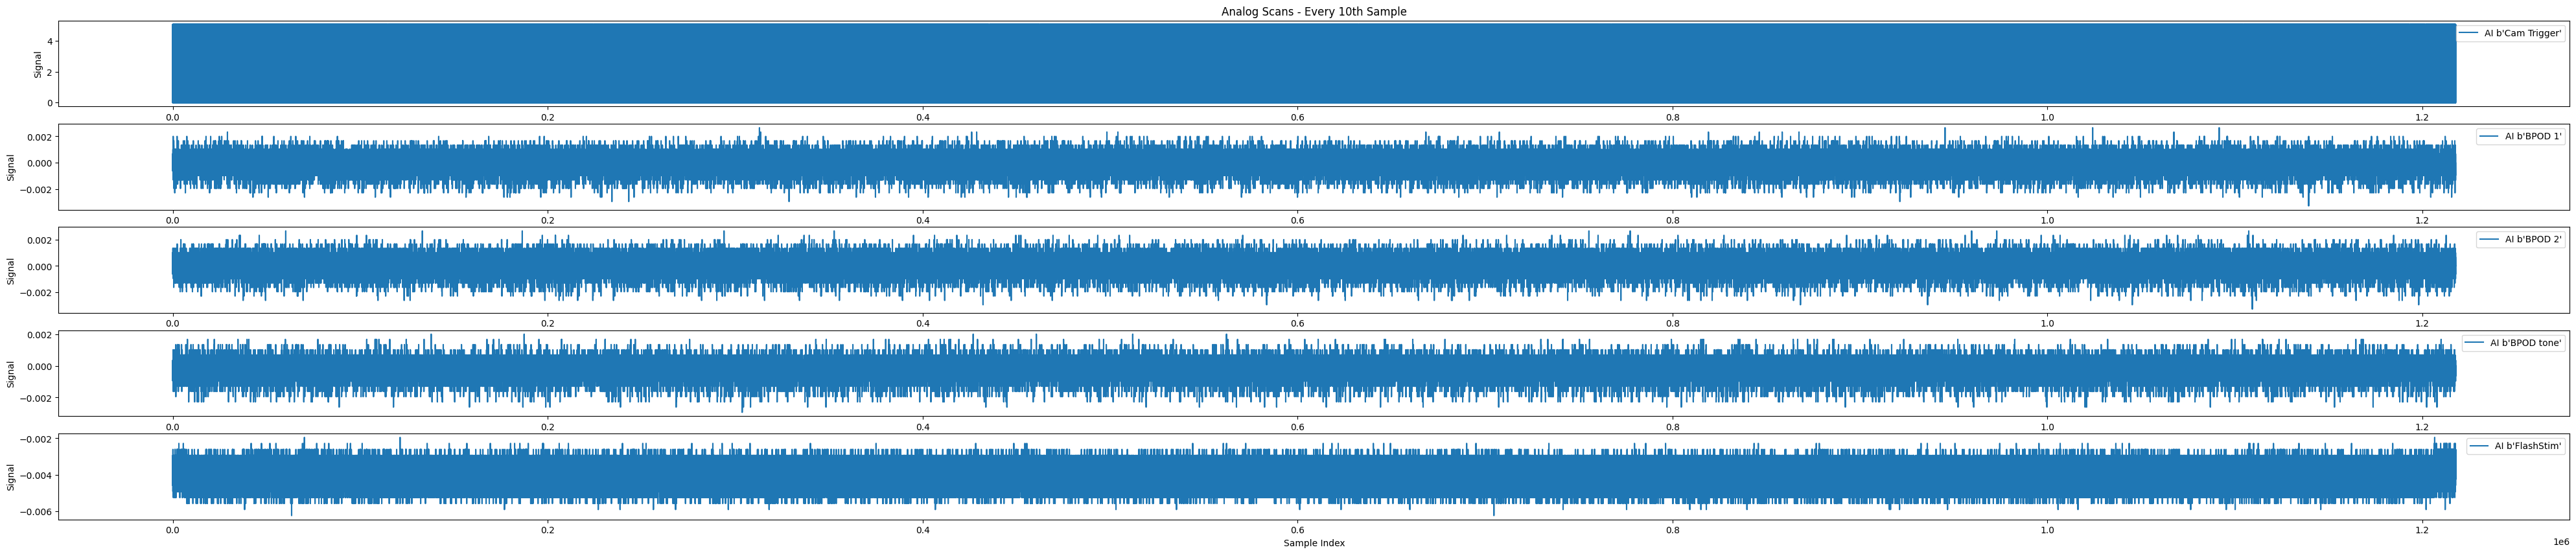

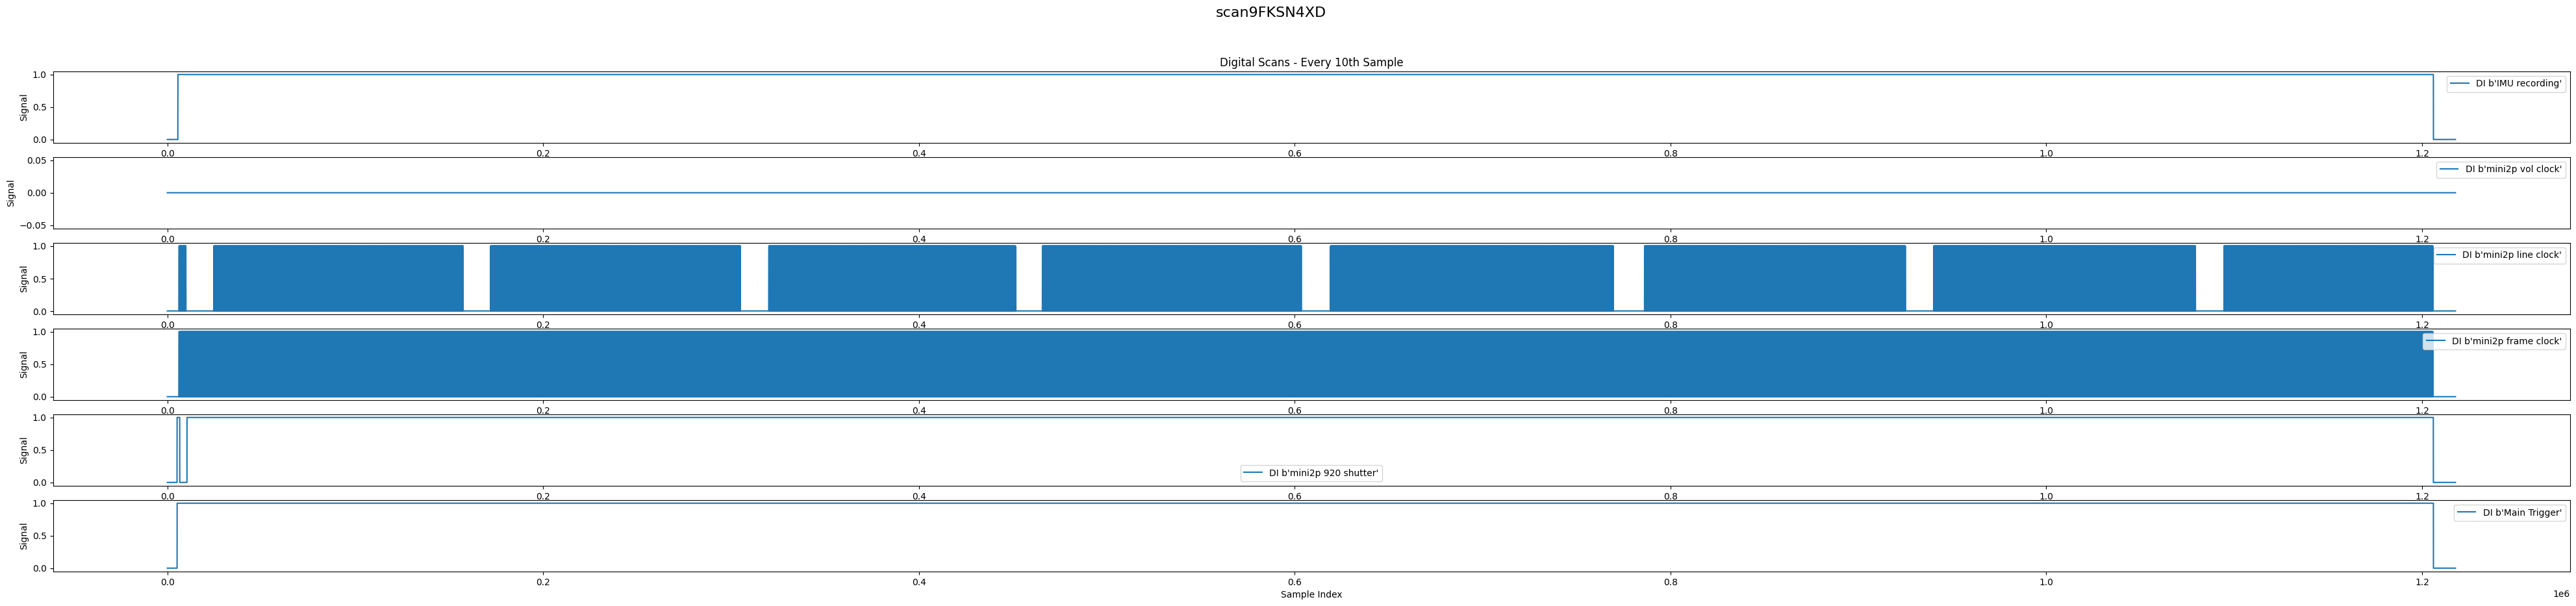

In [19]:
import numpy as np

analog_scans = curr_file[sweep]['analogScans']
analog_labels = curr_file['header']['AIChannelNames']
digital_labels = curr_file['header']['DIChannelNames']
sr = curr_file['header']['AcquisitionSampleRate'][0][0]
digital_scans = ibe.demultiplex(curr_file[sweep]['digitalScans'][0], np.shape(digital_labels)[0])
step = 10

# Plotting analogScans
# plt.figure(figsize=(12, 6))
# plt.title("Analog Scans")

# Creating subplots
fig, axes = plt.subplots(nrows=analog_scans.shape[0], ncols=1, figsize=(50, 10))

# Plotting analogScans
axes[0].set_title(f"Analog Scans - Every {step}th Sample")
for i in range(analog_scans.shape[0]):
     axes[i].plot(analog_scans[i][::step], label=f"AI {analog_labels[i]}")
     axes[i].legend()
     axes[i].set_xlabel("Sample Index")
     axes[i].set_ylabel("Signal")

plt.show()


# Creating subplots
fig, axes = plt.subplots(nrows=digital_scans.shape[0], ncols=1, figsize=(50, 10))

# Plotting analogScans
axes[0].set_title(f"Digital Scans - Every {step}th Sample")
for i in range(digital_scans.shape[0]):
     axes[i].plot(digital_scans[i][::step], label=f"DI {digital_labels[::-1][i]}")
     axes[i].set_xlabel("Sample Index")
     axes[i].set_ylabel("Signal")
     axes[i].legend()
     
fig.suptitle(scan_key["scan_id"], fontsize=16)

plt.show()


NameError: name 'stims_per_trial' is not defined

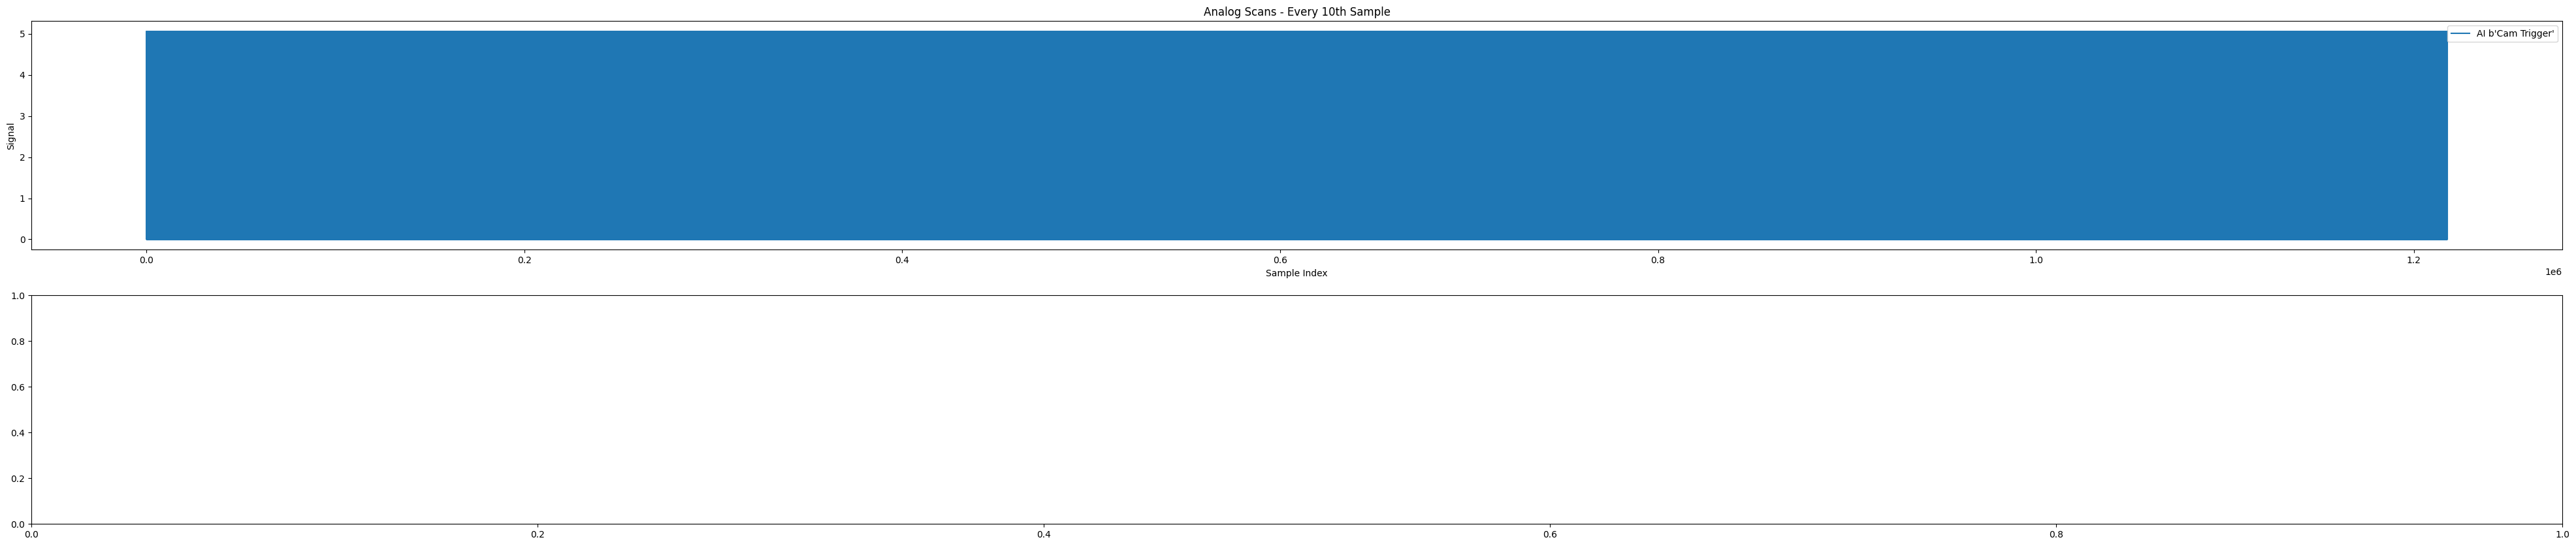

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(50, 10))
sr = curr_file['header']['AcquisitionSampleRate'][0][0]
# Plotting analogScans
axes[0].set_title(f"Analog Scans - Every {step}th Sample")
# for i in range(analog_scans.shape[0]):
i = 0
axes[i].plot(np.abs(analog_scans[i][::step]), label=f"AI {analog_labels[i]}")
axes[i].legend()
axes[i].set_xlabel("Sample Index")
axes[i].set_ylabel("Signal")


if i == 0:
     onsets = (event.Event & scan_key & "event_type = 'aux_bonsai_vis'").fetch('event_start_time') * sr / step
     offsets = (event.Event & scan_key & "event_type = 'aux_bonsai_vis'").fetch('event_end_time') * sr / step
     edges = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_start_time",order_by = "event_start_time")[::stims_per_trial] * sr / step
     edgesoff = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_end_time",order_by = "event_end_time")[stims_per_trial-1::stims_per_trial] * sr / step
     for xc in onsets:
          axes[i].axvline(x=xc, color = 'r')
     for xc in offsets:
          # axes[i].axvline(x=xc, color = 'r')
          axes[i].axvline(x=xc, color = 'w')
     for xc in edges:
          # axes[i].axvline(x=xc, color = 'r')
          axes[i].axvline(x=xc, color = 'b')
     for xc in edgesoff:
          # axes[i].axvline(x=xc, color = 'r')
          axes[i].axvline(x=xc, color = 'y')

In [ ]:
ibe.get_timestamps(np.abs(analog_scans[i]), sr, 1)

In [ ]:
event.Event & scan_key

In [ ]:
(event.Event & scan_key & "event_type = 'aux_bonsai_vis'").fetch('event_start_time')
# auxgatetimestamp_end = (event.Event()  &  "event_type='main_track_gate'" &  scanquery ).fetch('event_end_time')

In [ ]:
dj.Diagram(trial) + dj.Diagram(event) +100


In [ ]:
surgery

In [ ]:
dj.Diagram(subject.Subject) + dj.Diagram(event) + dj.Diagram(scan)

In [ ]:
fp = event.BehaviorRecording.File().fetch('filepath')
print(fp)


In [ ]:
scan.Scan()

In [ ]:
event.AlignmentEvent()

In [ ]:
trial.Trial()

In [ ]:
dj.Diagram(event)

In [ ]:
session.Session * session.SessionDirectory

In [ ]:
key='scan9FF6U114'
(scan.Scan & f'scan_id=\"{key}\"')

In [ ]:
scan.Scan()

`CB DEV NOTE:` In demo file, there are no `scan.motor_position_at_zero` values. Set to 0 here to avoid downstream type errors when adding. Future would should set these to null when not present and revise downstream code.

In [ ]:
scan.ScanInfo()

In [ ]:
scan.ScanInfo.Field()

Note the relative path below:

In [ ]:
scan.ScanInfo.ScanFile()

In [ ]:
event.BehaviorRecording.File()


In [ ]:
(event.BehaviorRecording.File ).fetch1("filepath")

# Treadmill handling and ingestion

In [ ]:
behavior.TreadmillDevice()

In [ ]:
behavior.TreadmillRecording.Channel() 

In [ ]:
treadmill = (behavior.TreadmillRecording.Channel() & scan_key).fetch("data")[0]
time = (behavior.TreadmillRecording.Channel() & scan_key).fetch("time")[0]

In [ ]:
# smoothing window size (ms)
window = 1000

# convert voltage to degree
treadmillnorm = (treadmill-np.min(treadmill)) / np.max(treadmill) * 360

# compute running speed (see function above)
angular_velocity_smoothed, unwrapped_angle_smoothed = ibe.compute_angular_velocity(time, treadmillnorm, window)


fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(25, 10))
# plt.rcParams['agg.path.chunksize'] = 10000  # Add this line if it does not rende

# Plotting the time series
axes[0].plot(time, treadmillnorm)
axes[0].set_ylim([-10, 370])
axes[0].set_ylabel("Wheel position [degree]")
axes[0].set_xlabel("Time [s]")

axes[1].plot(time[:-window+1],unwrapped_angle_smoothed )
# axes[1].set_ylim([-10000, 10000])
axes[1].set_ylabel("Unwrapped wheel position [cumulative degree]")
axes[1].set_xlabel("Time [s]")

axes[2].plot(time[:-window],angular_velocity_smoothed)
axes[2].set_ylim([-100, 500])
axes[2].set_ylabel("Running speed [degree / s]")
axes[2].set_xlabel("Time [s]")

# plt.show() 

In [ ]:
dj.Diagram(behavior) + dj.Diagram(event)-10 + dj.Diagram(trial)